# Team Raj Datathon 2025

### Imports & Config

In [54]:
# Cell 0 — Imports, config, and selections

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.metrics import mean_squared_error

from darts import TimeSeries
from darts.models import NaiveSeasonal, ExponentialSmoothing, Theta, LinearRegressionModel, AutoARIMA
from darts.utils.utils import SeasonalityMode, ModelMode

SEASON_WEEKS = 15   # weeks per season to model
RESORT = None       # e.g. "Mt. Buller" (set after loading data)
YEAR_TO_PLOT = 2024 # change if needed

# Cache for leaderboard so we don't rerun models
BACKTEST_SUMMARY = {}  # model_name -> mean_rmse

np.random.seed(42)


### Load + Clean Data

In [55]:
# Load
vis = pd.read_csv("data/visitation_data.csv")

# Find Year/Week columns (case-insensitive, without renaming)
def _find_col(cols, target):
    for c in cols:
        if str(c).strip().lower() == target:
            return c
    raise KeyError(f"Missing required column '{target}' (case-insensitive).")

YEAR = _find_col(vis.columns, "year")
WEEK = _find_col(vis.columns, "week")
id_cols = [YEAR, WEEK]
resort_cols = [c for c in vis.columns if c not in id_cols]

# Ensure numeric
vis[YEAR] = pd.to_numeric(vis[YEAR], errors="coerce").astype("Int64")
vis[WEEK] = pd.to_numeric(vis[WEEK], errors="coerce").astype("Int64")
vis[resort_cols] = vis[resort_cols].apply(pd.to_numeric, errors="coerce")

# Simple imputation: within-week median, then global median
vis[resort_cols] = vis.groupby(WEEK)[resort_cols].transform(lambda df: df.fillna(df.median()))
vis[resort_cols] = vis[resort_cols].fillna(vis[resort_cols].median())

# Drop disrupted seasons
vis = vis[~vis[YEAR].isin([2020, 2021])].copy()

# Pick a default resort if not set
if RESORT is None:
    RESORT = resort_cols[0]

print("Resorts available:", resort_cols)
print("Using RESORT:", RESORT)

def to_ts(values_1d):
    """Evenly spaced weekly TimeSeries for Darts."""
    idx = pd.date_range("2000-06-09", periods=len(values_1d), freq="7D")
    return TimeSeries.from_times_and_values(idx, np.asarray(values_1d))

def build_hist_for_resort(resort_name: str) -> pd.DataFrame:
    """Return tidy (YEAR, WEEK, Visitors) filtered to weeks 1..15, sorted."""
    df = (
        vis.loc[vis[WEEK].between(1, SEASON_WEEKS), [YEAR, WEEK, resort_name]]
           .rename(columns={resort_name: "Visitors"})
           .dropna(subset=["Visitors"])
           .sort_values([YEAR, WEEK])
           .reset_index(drop=True)
    )
    return df


Resorts available: ['Mt. Baw Baw', 'Mt. Stirling', 'Mt. Hotham', 'Falls Creek', 'Mt. Buller', 'Selwyn', 'Thredbo', 'Perisher', 'Charlotte Pass']
Using RESORT: Mt. Baw Baw


### Backtest & Plot Function

In [56]:
def backtest_and_plot(resort_name: str,
                      model_name: str,
                      builder_fn,
                      min_train_len: int,
                      year_to_plot: int = YEAR_TO_PLOT):
    """
    1) Backtest per-year (rolling one-year-ahead) -> returns mean RMSE across eligible years.
    2) Fit on all years < year_to_plot, predict that year, plot Pred vs Actual, and print that year's RMSE.
    If year_to_plot is missing, falls back to the latest available year.
    """
    hist = build_hist_for_resort(resort_name)
    years_all = sorted(hist[YEAR].unique())

    # ---------- Backtest (rolling y-1 -> y) ----------
    rmses = []
    for y in years_all:
        tr = hist[hist[YEAR] < y]
        te = hist[hist[YEAR] == y]
        if te.empty or len(tr) < min_train_len:
            continue

        tr_ts = to_ts(tr["Visitors"].to_numpy())
        te_ts = to_ts(te["Visitors"].to_numpy())
        H = len(te_ts)

        try:
            model = builder_fn()
            model.fit(tr_ts)
            fc = model.predict(H)
            rmse = mean_squared_error(te_ts.values().ravel(), fc.values().ravel())
            rmses.append(rmse)
        except Exception:
            continue  # keep it simple; skip problematic folds

    mean_rmse = float(np.mean(rmses)) if rmses else np.nan

    # ---------- Year plot (year_to_plot or fallback) ----------
    year = year_to_plot if year_to_plot in years_all else (years_all[-1] if years_all else None)
    rmse_year = np.nan
    if year is not None:
        tr = hist[hist[YEAR] < year]
        te = hist[hist[YEAR] == year]
        if not te.empty and len(tr) >= min_train_len:
            tr_ts = to_ts(tr["Visitors"].to_numpy())
            te_ts = to_ts(te["Visitors"].to_numpy())
            H = len(te_ts)
            try:
                model = builder_fn()
                model.fit(tr_ts)
                fc = model.predict(H)

                y_true = te_ts.values().ravel()
                y_pred = fc.values().ravel()
                rmse_year = mean_squared_error(y_true, y_pred)

                # Plot
                weeks = te[WEEK].to_numpy()
                plt.figure(figsize=(8, 4.5))
                plt.plot(weeks, y_true, marker='o', label=f'Actual {year}')
                plt.plot(weeks, y_pred, marker='o', linestyle='--', label=f'{model_name} pred')
                plt.xlabel('Week'); plt.ylabel('Visitors')
                plt.title(f'{resort_name} — {model_name}  ({year})  RMSE={rmse_year:.2f}')
                plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
                print(f"{model_name}: Backtested mean RMSE = {mean_rmse:.2f} | {year} RMSE = {rmse_year:.2f}")
            except Exception as e:
                print(f"{model_name}: plot year failed — {e}")
        else:
            print(f"{model_name}: Not enough data to plot year {year}.")
    else:
        print(f"{model_name}: No data available for plotting.")

    return mean_rmse, rmse_year


### Seasonal Naive

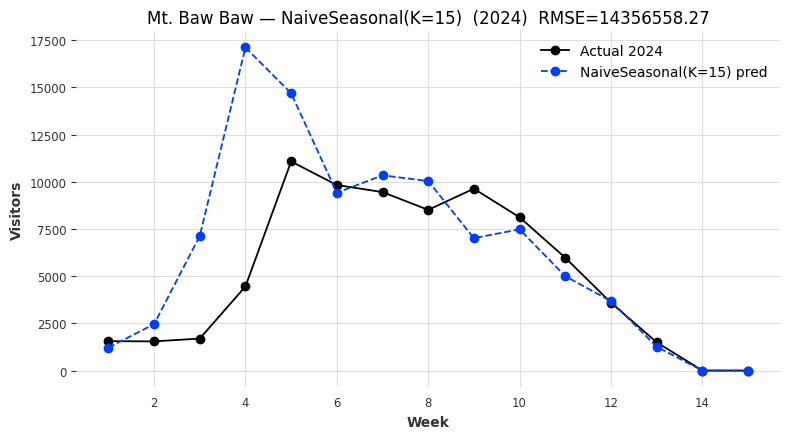

NaiveSeasonal(K=15): Backtested mean RMSE = 10512545.49 | 2024 RMSE = 14356558.27


In [57]:
MODEL_NAME = "NaiveSeasonal(K=15)"
BUILDER    = lambda: NaiveSeasonal(K=SEASON_WEEKS)
MIN_TRAIN  = SEASON_WEEKS  # ≥ 1 season

mean_rmse, rmse_yr = backtest_and_plot(RESORT, MODEL_NAME, BUILDER, MIN_TRAIN, YEAR_TO_PLOT)
BACKTEST_SUMMARY[MODEL_NAME] = mean_rmse

### Exponential Smoothing

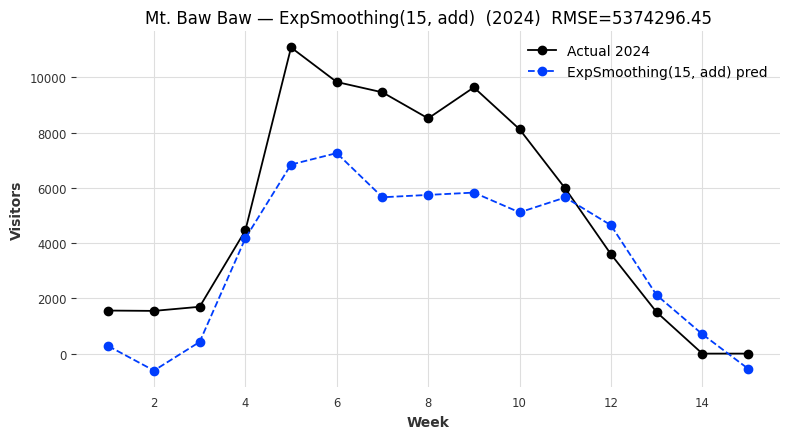

ExpSmoothing(15, add): Backtested mean RMSE = 10366431.57 | 2024 RMSE = 5374296.45


In [58]:
MODEL_NAME = "ExpSmoothing(15, add)"
BUILDER    = lambda: ExponentialSmoothing(
    seasonal=SeasonalityMode.ADDITIVE,
    seasonal_periods=SEASON_WEEKS,
    trend=ModelMode.NONE
)
MIN_TRAIN  = 2 * SEASON_WEEKS  # ≥ 2 seasons

mean_rmse, rmse_yr = backtest_and_plot(RESORT, MODEL_NAME, BUILDER, MIN_TRAIN, YEAR_TO_PLOT)
BACKTEST_SUMMARY[MODEL_NAME] = mean_rmse

### Theta

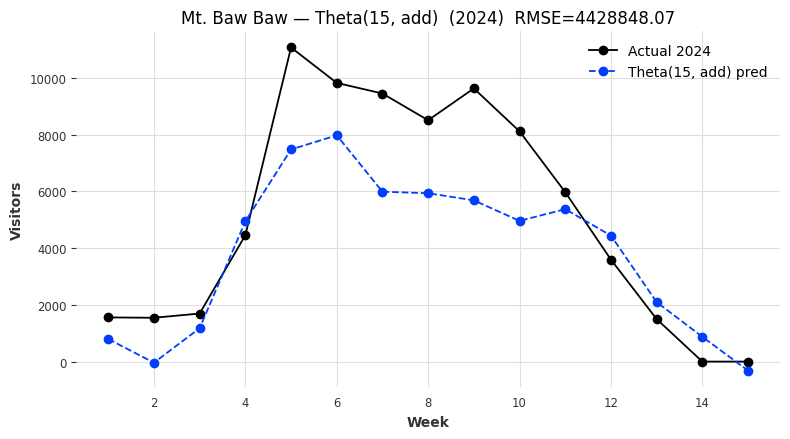

Theta(15, add): Backtested mean RMSE = 9174557.80 | 2024 RMSE = 4428848.07


In [59]:
MODEL_NAME = "Theta(15, add)"
BUILDER    = lambda: Theta(
    seasonality_period=SEASON_WEEKS,
    season_mode=SeasonalityMode.ADDITIVE
)
MIN_TRAIN  = 2 * SEASON_WEEKS  # ≥ 2 seasons

mean_rmse, rmse_yr = backtest_and_plot(RESORT, MODEL_NAME, BUILDER, MIN_TRAIN, YEAR_TO_PLOT)
BACKTEST_SUMMARY[MODEL_NAME] = mean_rmse

### Linear Regression

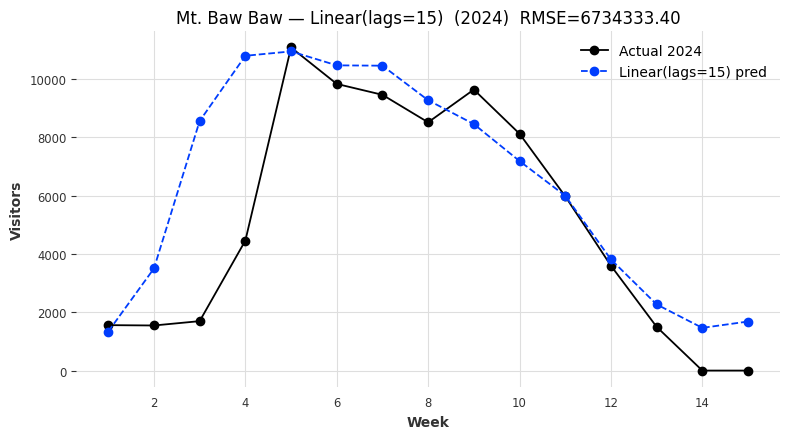

Linear(lags=15): Backtested mean RMSE = 11417483.41 | 2024 RMSE = 6734333.40


In [60]:
MODEL_NAME = "Linear(lags=15)"
BUILDER    = lambda: LinearRegressionModel(lags=SEASON_WEEKS)
MIN_TRAIN  = SEASON_WEEKS + 1  # need > 15 points

mean_rmse, rmse_yr = backtest_and_plot(RESORT, MODEL_NAME, BUILDER, MIN_TRAIN, YEAR_TO_PLOT)
BACKTEST_SUMMARY[MODEL_NAME] = mean_rmse

### Auto Arima

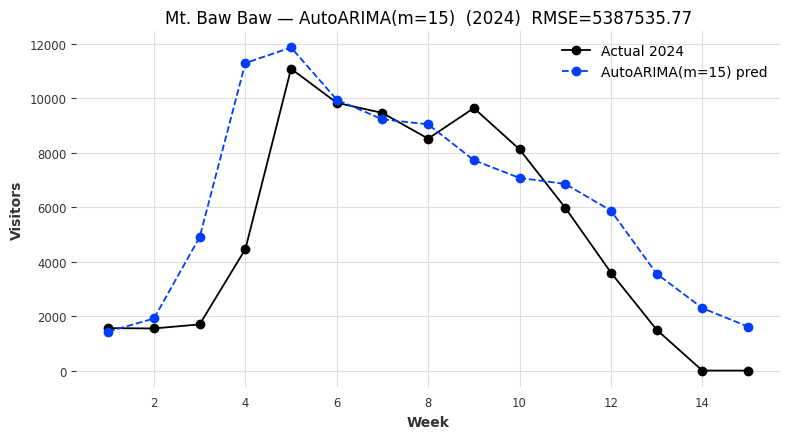

AutoARIMA(m=15): Backtested mean RMSE = 10669444.39 | 2024 RMSE = 5387535.77


In [61]:
MODEL_NAME = "AutoARIMA(m=15)"
BUILDER    = lambda: AutoARIMA(season_length=SEASON_WEEKS)
MIN_TRAIN  = 2 * SEASON_WEEKS  # ≥ 2 seasons is safer

mean_rmse, rmse_yr = backtest_and_plot(RESORT, MODEL_NAME, BUILDER, MIN_TRAIN, YEAR_TO_PLOT)
BACKTEST_SUMMARY[MODEL_NAME] = mean_rmse

### Leaderboard

In [62]:
# --- helper: mean backtest RMSE for one resort/model (no plotting) ---
def backtest_mean_only(resort_name, builder_fn, min_train_len):
    hist = build_hist_for_resort(resort_name)
    years_all = sorted(hist[YEAR].unique())
    rmses = []
    for y in years_all:
        tr = hist[hist[YEAR] < y]
        te = hist[hist[YEAR] == y]
        if te.empty or len(tr) < min_train_len:
            continue
        tr_ts = to_ts(tr["Visitors"].to_numpy())
        te_ts = to_ts(te["Visitors"].to_numpy())
        H = len(te_ts)
        try:
            m = builder_fn()
            m.fit(tr_ts)
            fc = m.predict(H)
            rmse = mean_squared_error(te_ts.values().ravel(), fc.values().ravel())
            rmses.append(rmse)
        except Exception:
            pass
    return float(np.mean(rmses)) if rmses else np.nan

# --- model suite (same settings as earlier cells) ---
model_suite = [
    ("NaiveSeasonal(K=15)", lambda: NaiveSeasonal(K=SEASON_WEEKS), SEASON_WEEKS),
    ("ExpSmoothing(15, add)", lambda: ExponentialSmoothing(
        seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=SEASON_WEEKS, trend=ModelMode.NONE
    ), 2 * SEASON_WEEKS),
    ("Theta(15, add)", lambda: Theta(seasonality_period=SEASON_WEEKS, season_mode=SeasonalityMode.ADDITIVE), 2 * SEASON_WEEKS),
    ("Linear(lags=15)", lambda: LinearRegressionModel(lags=SEASON_WEEKS), SEASON_WEEKS + 1),
    ("AutoARIMA(m=15)", lambda: AutoARIMA(season_length=SEASON_WEEKS), 2 * SEASON_WEEKS),
]

# --- optional weights: average visitation per resort (normalized) ---
resort_weights = {r: float(np.nanmean(vis[r].to_numpy())) for r in resort_cols}
sum_w = sum(w for w in resort_weights.values() if np.isfinite(w) and w > 0)
if sum_w <= 0:
    resort_weights = {r: 1.0 for r in resort_cols}
    sum_w = float(len(resort_cols))
resort_weights = {r: w / sum_w for r, w in resort_weights.items()}

def safe_weighted(values, weights):
    vals = np.asarray(values, dtype=float)
    w = np.asarray(weights, dtype=float)
    if len(vals) == 0 or len(w) == 0:
        return np.nan
    mask = np.isfinite(vals) & np.isfinite(w) & (w > 0)
    if not np.any(mask):
        return np.nan
    return float(np.average(vals[mask], weights=w[mask]))

# --- compute per-model metrics across all resorts ---
rows = []
for name, builder, min_train in model_suite:
    per_resort_rmse, per_resort_w = [], []
    for r in resort_cols:
        m = backtest_mean_only(r, builder, min_train)
        if np.isfinite(m):
            per_resort_rmse.append(m)
            per_resort_w.append(resort_weights.get(r, 0.0))
    mean_rmse   = float(np.mean(per_resort_rmse)) if per_resort_rmse else np.nan
    median_rmse = float(np.median(per_resort_rmse)) if per_resort_rmse else np.nan
    weighted_rmse = safe_weighted(per_resort_rmse, per_resort_w)
    rows.append({
        "Model": name,
        "Resorts_Covered": len(per_resort_rmse),
        "Mean_RMSE": mean_rmse,
        "Median_RMSE": median_rmse,
        "Weighted_RMSE": weighted_rmse,
    })

board_all = (
    pd.DataFrame(rows)
      .sort_values(["Mean_RMSE", "Weighted_RMSE"], ascending=[True, True], na_position="last")
      .reset_index(drop=True)
)

print("GLOBAL Leaderboard across ALL resorts (lower RMSE is better):")
display(board_all)

GLOBAL Leaderboard across ALL resorts (lower RMSE is better):


,Model,Resorts_Covered,Mean_RMSE,Median_RMSE,Weighted_RMSE
0,"Theta(15, add)",9,3.877598e+07,2.929904e+07,6.896111e+07
1,NaiveSeasonal(K=15),9,4.088830e+07,2.659969e+07,7.237823e+07
2,"ExpSmoothing(15, add)",9,4.346519e+07,3.022659e+07,7.714131e+07
3,AutoARIMA(m=15),9,5.257532e+07,4.003708e+07,9.435162e+07
4,Linear(lags=15),9,6.615400e+07,5.581361e+07,1.162112e+08


### Ensemble (Theta + NaiveSeasonal)

Ensemble(Theta+Naive) — GLOBAL metrics across ALL resorts (lower is better):


,Model,Resorts_Covered,Mean_RMSE,Median_RMSE,Weighted_RMSE
0,Ensemble(Theta+Naive),9,3.513589e+07,2.608239e+07,6.235730e+07


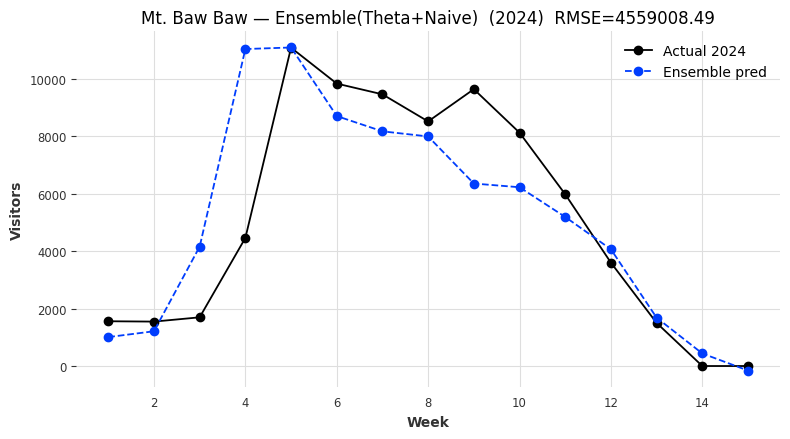

Ensemble(Theta+Naive): Mt. Baw Baw 2024 RMSE = 4559008.49


In [66]:
from darts.models import Theta, NaiveSeasonal
from darts.utils.utils import SeasonalityMode

# --- config: ensemble needs enough history for BOTH models (Theta needs >= 30 points) ---
MIN_TRAIN_ENSEMBLE = 2 * SEASON_WEEKS  # 30

def _ensemble_predict(tr_ts, horizon):
    """Fit Theta + NaiveSeasonal on training series and return the averaged prediction array."""
    m_theta = Theta(seasonality_period=SEASON_WEEKS, season_mode=SeasonalityMode.ADDITIVE)
    m_naive = NaiveSeasonal(K=SEASON_WEEKS)
    m_theta.fit(tr_ts)
    m_naive.fit(tr_ts)
    fc_theta = m_theta.predict(horizon).values().ravel()
    fc_naive = m_naive.predict(horizon).values().ravel()
    return 0.5 * (fc_theta + fc_naive)

def ensemble_backtest_mean_only(resort_name):
    """Mean backtested RMSE for the ensemble across eligible years for one resort."""
    hist = build_hist_for_resort(resort_name)
    years_all = sorted(hist[YEAR].unique())
    rmses = []
    for y in years_all:
        tr = hist[hist[YEAR] < y]
        te = hist[hist[YEAR] == y]
        if te.empty or len(tr) < MIN_TRAIN_ENSEMBLE:
            continue
        tr_ts = to_ts(tr["Visitors"].to_numpy())
        te_ts = to_ts(te["Visitors"].to_numpy())
        H = len(te_ts)
        try:
            y_pred = _ensemble_predict(tr_ts, H)
            rmse = mean_squared_error(te_ts.values().ravel(), y_pred)
            rmses.append(rmse)
        except Exception:
            pass
    return float(np.mean(rmses)) if rmses else np.nan

def _safe_weights():
    """Average visitation per resort (normalized)."""
    w = {r: float(np.nanmean(vis[r].to_numpy())) for r in resort_cols}
    s = sum(val for val in w.values() if np.isfinite(val) and val > 0)
    if s <= 0:
        w = {r: 1.0 for r in resort_cols}; s = float(len(resort_cols))
    return {r: val / s for r, val in w.items()}

def _safe_weighted(values, weights):
    vals = np.asarray(values, dtype=float)
    w = np.asarray(weights, dtype=float)
    if len(vals) == 0 or len(w) == 0:
        return np.nan
    mask = np.isfinite(vals) & np.isfinite(w) & (w > 0)
    if not np.any(mask):
        return np.nan
    return float(np.average(vals[mask], weights=w[mask]))

# --- compute metrics across ALL resorts ---
per_resort_rmse = []
per_resort_weights = []
weights_map = _safe_weights()

for r in resort_cols:
    m = ensemble_backtest_mean_only(r)
    if np.isfinite(m):
        per_resort_rmse.append(m)
        per_resort_weights.append(weights_map.get(r, 0.0))

mean_rmse   = float(np.mean(per_resort_rmse)) if per_resort_rmse else np.nan
median_rmse = float(np.median(per_resort_rmse)) if per_resort_rmse else np.nan
weighted_rmse = _safe_weighted(per_resort_rmse, per_resort_weights)

board_ensemble = pd.DataFrame([{
    "Model": "Ensemble(Theta+Naive)",
    "Resorts_Covered": len(per_resort_rmse),
    "Mean_RMSE": mean_rmse,
    "Median_RMSE": median_rmse,
    "Weighted_RMSE": weighted_rmse,
}])

print("Ensemble(Theta+Naive) — GLOBAL metrics across ALL resorts (lower is better):")
display(board_ensemble)

# --- plot 2024 (or latest available year) for the selected RESORT ---
def ensemble_plot_year(resort_name, year_to_plot=YEAR_TO_PLOT):
    hist = build_hist_for_resort(resort_name)
    years_all = sorted(hist[YEAR].unique())
    if not years_all:
        print("No data available.")
        return

    year = year_to_plot if year_to_plot in years_all else years_all[-1]
    tr = hist[hist[YEAR] < year]
    te = hist[hist[YEAR] == year]
    if te.empty or len(tr) < MIN_TRAIN_ENSEMBLE:
        print(f"Not enough data to plot {resort_name} {year} (need ≥{MIN_TRAIN_ENSEMBLE} train points).")
        return

    tr_ts = to_ts(tr["Visitors"].to_numpy())
    te_ts = to_ts(te["Visitors"].to_numpy())
    H = len(te_ts)

    try:
        y_pred = _ensemble_predict(tr_ts, H)
        y_true = te_ts.values().ravel()
        rmse_year = mean_squared_error(y_true, y_pred)

        weeks = te[WEEK].to_numpy()
        plt.figure(figsize=(8, 4.5))
        plt.plot(weeks, y_true, marker='o', label=f'Actual {year}')
        plt.plot(weeks, y_pred, marker='o', linestyle='--', label='Ensemble pred')
        plt.xlabel('Week'); plt.ylabel('Visitors')
        plt.title(f'{resort_name} — Ensemble(Theta+Naive)  ({year})  RMSE={rmse_year:.2f}')
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
        print(f'Ensemble(Theta+Naive): {resort_name} {year} RMSE = {rmse_year:.2f}')
    except Exception as e:
        print(f"Ensemble plot failed — {e}")

ensemble_plot_year(RESORT, YEAR_TO_PLOT)


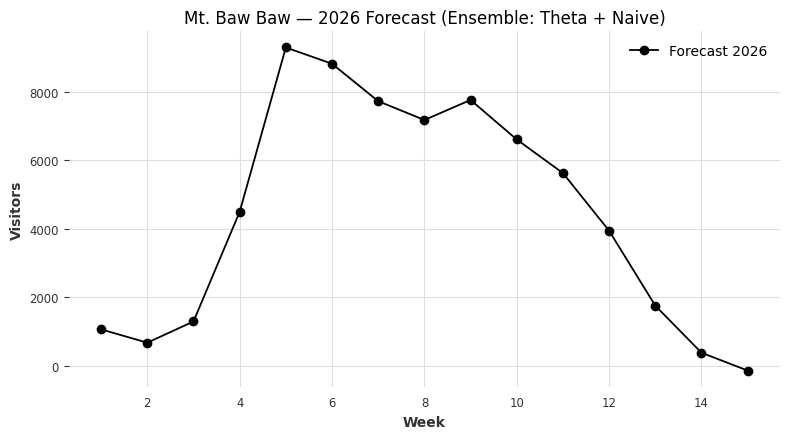

,Week,Predicted_Visitors
0,1,1061
1,2,671
2,3,1291
3,4,4495
4,5,9298
5,6,8823
6,7,7729
7,8,7179
8,9,7764
9,10,6609


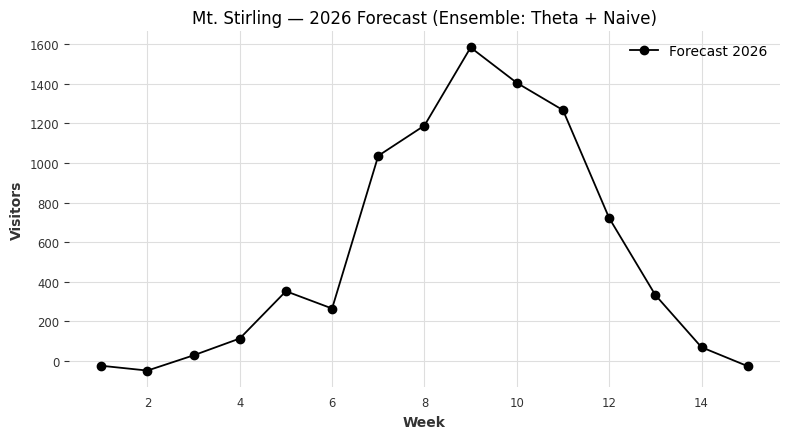

,Week,Predicted_Visitors
0,1,-25
1,2,-50
2,3,27
3,4,112
4,5,352
5,6,264
6,7,1036
7,8,1189
8,9,1584
9,10,1405


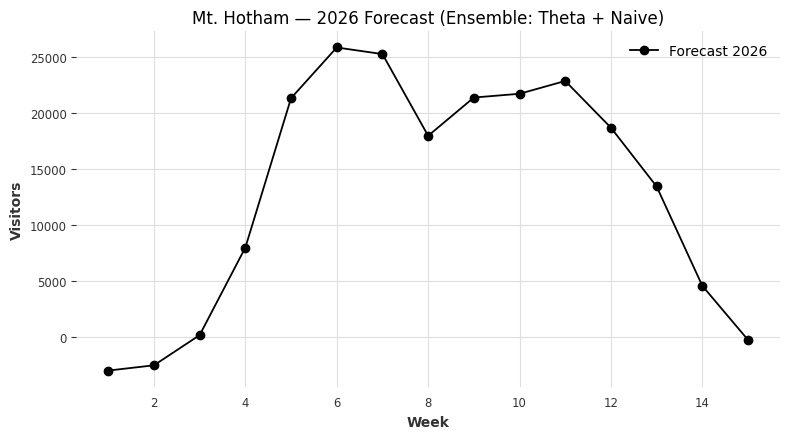

,Week,Predicted_Visitors
0,1,-3014
1,2,-2544
2,3,151
3,4,7961
4,5,21290
5,6,25812
6,7,25224
7,8,17932
8,9,21346
9,10,21682


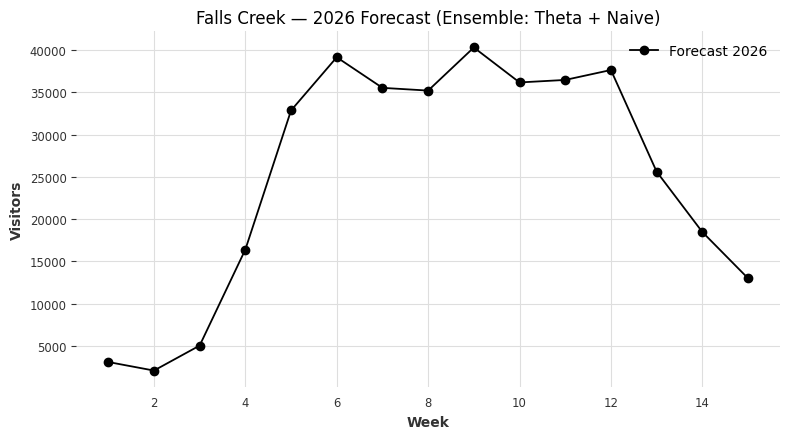

,Week,Predicted_Visitors
0,1,3079
1,2,2066
2,3,5026
3,4,16400
4,5,32870
5,6,39168
6,7,35546
7,8,35222
8,9,40325
9,10,36186


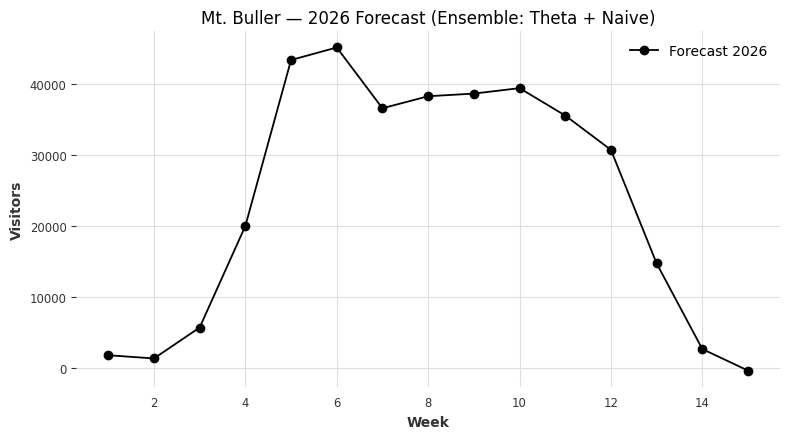

,Week,Predicted_Visitors
0,1,1803
1,2,1352
2,3,5705
3,4,20007
4,5,43378
5,6,45139
6,7,36582
7,8,38273
8,9,38648
9,10,39413


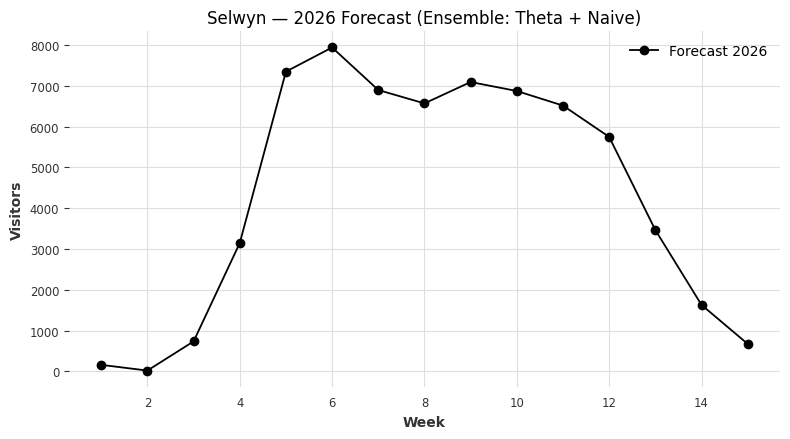

,Week,Predicted_Visitors
0,1,162
1,2,22
2,3,736
3,4,3146
4,5,7348
5,6,7939
6,7,6897
7,8,6569
8,9,7092
9,10,6872


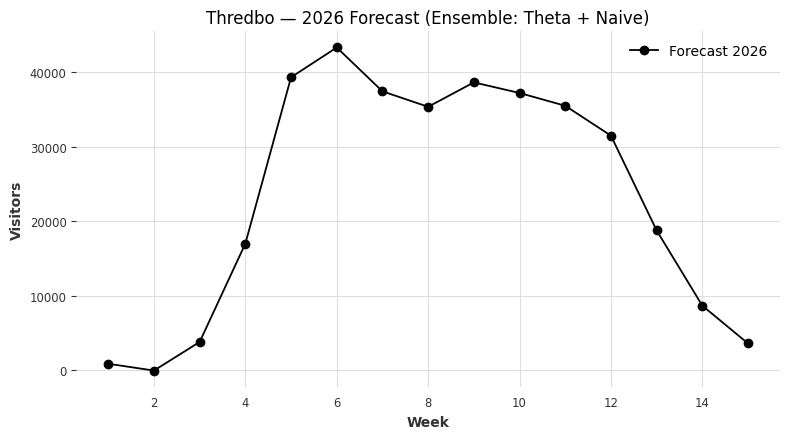

,Week,Predicted_Visitors
0,1,876
1,2,-36
2,3,3797
3,4,16985
4,5,39279
5,6,43277
6,7,37400
7,8,35325
8,9,38598
9,10,37179


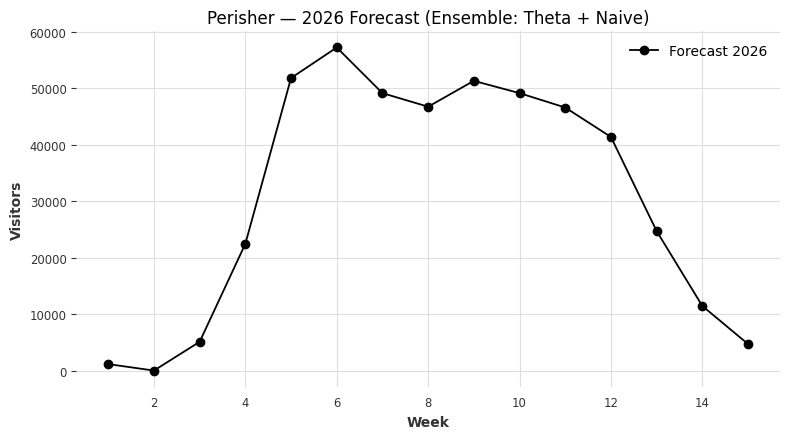

,Week,Predicted_Visitors
0,1,1159
1,2,16
2,3,5108
3,4,22460
4,5,51806
5,6,57213
6,7,49132
7,8,46729
8,9,51306
9,10,49131


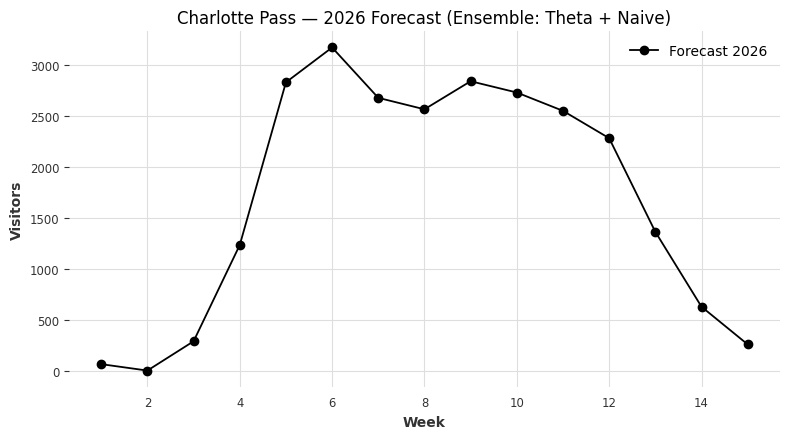

,Week,Predicted_Visitors
0,1,65
1,2,2
2,3,289
3,4,1232
4,5,2827
5,6,3168
6,7,2675
7,8,2562
8,9,2837
9,10,2727


In [65]:
YEAR_TO_FORECAST = 2026
MIN_TRAIN_ENSEMBLE = 2 * SEASON_WEEKS  # Theta needs >= 30 points

def _ensemble_predict_from_history(values_1d, horizon=SEASON_WEEKS):
    """
    Fit Theta + NaiveSeasonal on the given 1D training series (all past weeks),
    return equal-weight average forecast for the next `horizon` steps.
    Falls back to NaiveSeasonal if Theta can't be fit.
    """
    ts = to_ts(np.asarray(values_1d))
    try:
        m_theta = Theta(seasonality_period=SEASON_WEEKS, season_mode=SeasonalityMode.ADDITIVE)
        m_naive = NaiveSeasonal(K=SEASON_WEEKS)
        m_theta.fit(ts); m_naive.fit(ts)
        fc_theta = m_theta.predict(horizon).values().ravel()
        fc_naive = m_naive.predict(horizon).values().ravel()
        return 0.5 * (fc_theta + fc_naive)
    except Exception:
        # Fallback to Naive only
        m_naive = NaiveSeasonal(K=SEASON_WEEKS)
        m_naive.fit(ts)
        return m_naive.predict(horizon).values().ravel()

pred_rows = []
weeks = np.arange(1, SEASON_WEEKS + 1)

for r in resort_cols:
    hist = build_hist_for_resort(r)  # weeks 1..15 for all available years (post-clean)
    if len(hist) < SEASON_WEEKS:
        print(f"Skipping {r}: not enough history to forecast.")
        continue

    # Use ALL available history to forecast the next season (2026)
    y_pred = _ensemble_predict_from_history(hist["Visitors"].to_numpy(), horizon=SEASON_WEEKS)

    # Plot per-resort forecast
    plt.figure(figsize=(8, 4.5))
    plt.plot(weeks, y_pred, marker='o', linestyle='-', label=f'Forecast {YEAR_TO_FORECAST}')
    plt.xlabel('Week')
    plt.ylabel('Visitors')
    plt.title(f'{r} — {YEAR_TO_FORECAST} Forecast (Ensemble: Theta + Naive)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Quick table under the plot (rounded to nearest visitor)
    table_df = pd.DataFrame({
        "Week": weeks.astype(int),
        "Predicted_Visitors": np.rint(y_pred).astype(int)
    })
    display(table_df)

    # Collect predictions for CSV
    for w, val in zip(weeks, y_pred):
        pred_rows.append({
            "Resort": r,
            "Year": YEAR_TO_FORECAST,
            "Week": int(w),
            "Predicted_Visitors": float(val)
        })
